In [9]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from icecream import ic
%matplotlib inline

image_path = 'screenshot2.png'

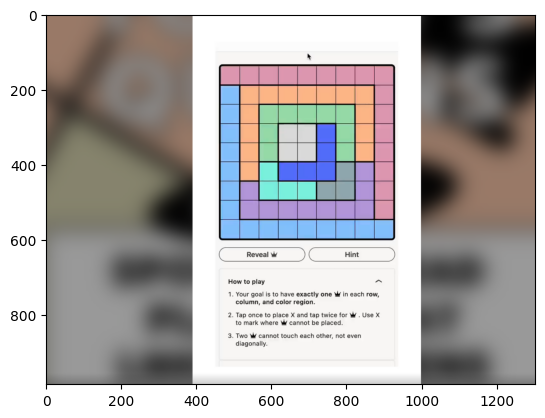

In [10]:
image = cv2.imread(image_path)
# show image
plt.imshow(image)
plt.show()

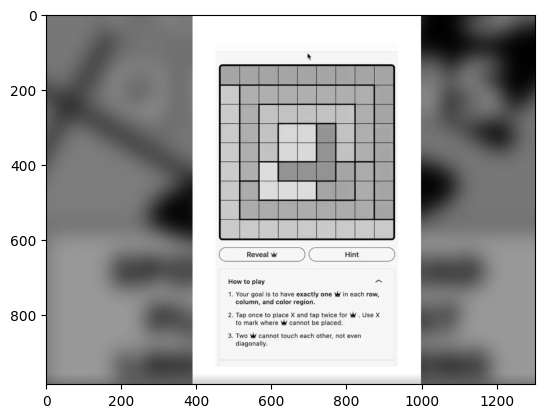

In [11]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')


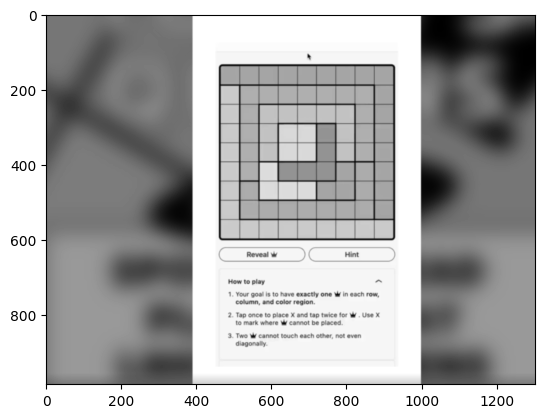

In [12]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')

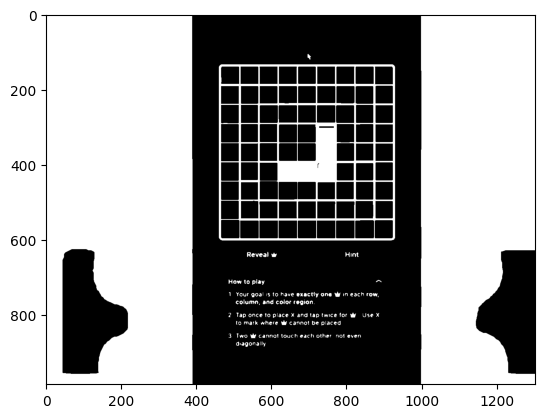

In [13]:
_, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap='gray')

In [14]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Total number of contours found: ", len(contours))
# visualize contours on black image
contour_image = np.zeros_like(gray)
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)
plt.imshow(contour_image, cmap='gray')
plt.show()

# visualize contours on original image
contour_image = np.copy(image)
cv2.drawContours(contour_image, contours, -1, (255, 0, 0), 2)
plt.imshow(contour_image)
plt.show()


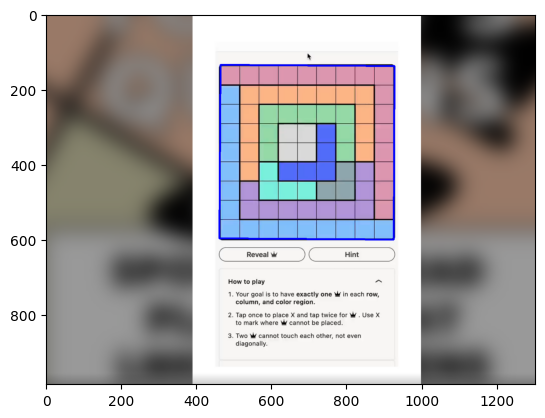

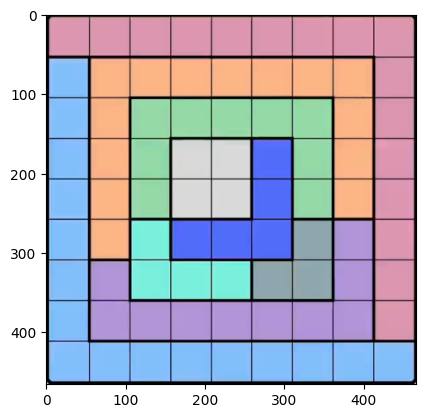

ic| grid_image.shape: (466, 467, 3)


(466, 467, 3)

In [7]:
# Find the contour that looks like the largest square (the grid)
largest_square_contour = None
max_area = 0

for contour in contours:
    # Approximate the contour to a polygon and check if it has 4 sides and 4 sides are equal in length
    approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
    area = cv2.contourArea(contour)
    if len(approx) == 4:
        lens = [np.linalg.norm(approx[i-1] - approx[i]) for i in range(4)]

        if max(lens) - min(lens) <= 10 and area > max_area:
            largest_square_contour = approx
            max_area = area

assert largest_square_contour is not None, 'Grid not found!'
# draw the largest square contour
largest_square_contour_image = np.copy(image)
cv2.drawContours(largest_square_contour_image, [largest_square_contour], -1, (0, 0, 255), 3)
plt.imshow(largest_square_contour_image)
plt.show()

# Get the bounding box of the grid
x, y, w, h = cv2.boundingRect(largest_square_contour)

grid_image = image[y:y+h, x:x+w]
plt.imshow(grid_image)
plt.show()
ic(grid_image.shape)

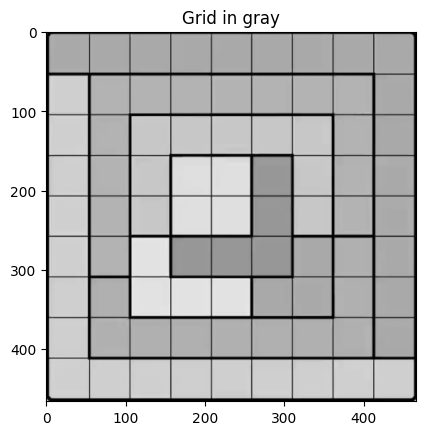

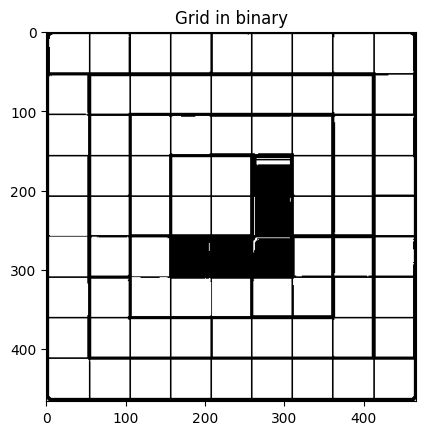

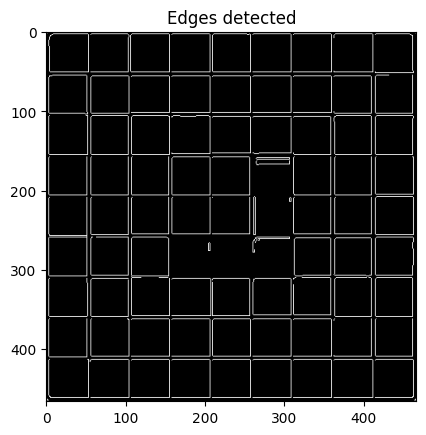

ic| len(merged_vertical_lines): 10, len(merged_horizontal_lines): 10


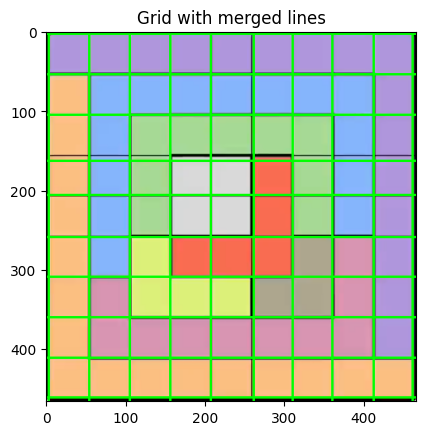

In [8]:
grid_gray = cv2.cvtColor(grid_image, cv2.COLOR_BGR2GRAY)
plt.imshow(grid_gray, cmap='gray')
plt.title("Grid in gray")
plt.show()

# convert gray to binary
_, grid_binary = cv2.threshold(grid_gray, 150, 255, cv2.THRESH_BINARY)

plt.imshow(grid_binary, cmap='gray')
plt.title("Grid in binary")
plt.show()

# Use Canny edge detection to find lines
edges = cv2.Canny(grid_binary, 50,150, apertureSize=3)

# Show the edges
plt.imshow(edges, cmap='gray')
plt.title("Edges detected")
plt.show()

# Sum pixel intensities along columns and rows to find grid lines
horizontal_sum = np.sum(edges, axis=1)
vertical_sum = np.sum(edges, axis=0)

# Find peaks in the horizontal and vertical sums
horizontal_lines = np.where(horizontal_sum > np.mean(horizontal_sum))[0]
vertical_lines = np.where(vertical_sum > np.mean(vertical_sum))[0]


# Function to merge close lines based on a threshold
def merge_close_lines(lines, threshold):
    if len(lines) == 0:
        return lines
    merged_lines = [lines[0]]
    for i in range(1, len(lines)):
        if lines[i] - merged_lines[-1] > threshold:
            merged_lines.append(lines[i])
        else:
            merged_lines[-1] = (merged_lines[-1] + lines[i]) // 2  # Average the close lines
    return merged_lines

# Define the threshold distance to merge lines
threshold = 10

# Merge close horizontal and vertical lines
merged_horizontal_lines = merge_close_lines(horizontal_lines, threshold)
merged_vertical_lines = merge_close_lines(vertical_lines, threshold)

ic(len(merged_vertical_lines), len(merged_horizontal_lines))

# Visualize the merged grid lines on the original grid image
grid_with_lines = np.copy(grid_image)
h, w = grid_image.shape[:2]

for line in merged_vertical_lines:
    cv2.line(grid_with_lines, (line, 0), (line, h), (0, 255, 0), 2)
for line in merged_horizontal_lines:
    cv2.line(grid_with_lines, (0, line), (w, line), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(grid_with_lines, cv2.COLOR_BGR2RGB))
plt.title("Grid with merged lines")
plt.show()